In [1]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers


In [2]:
(dataset_train_original, dataset_validate_original), info = tfds.load(
    "cats_vs_dogs",
    split=["train[:10%]","train[80%:]"],
    as_supervised=True,
    with_info=True
)
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete8D5LRH/cats_vs_dogs-train.tfrecord*...:   0%|    …

Dataset cats_vs_dogs downloaded and prepared to ~/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.0',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_path='~/tensorflow_datasets/cats_vs_dogs/4.0.0',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=689.64 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=8>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, John (JD) and Howell, Jon and

# Look at the data

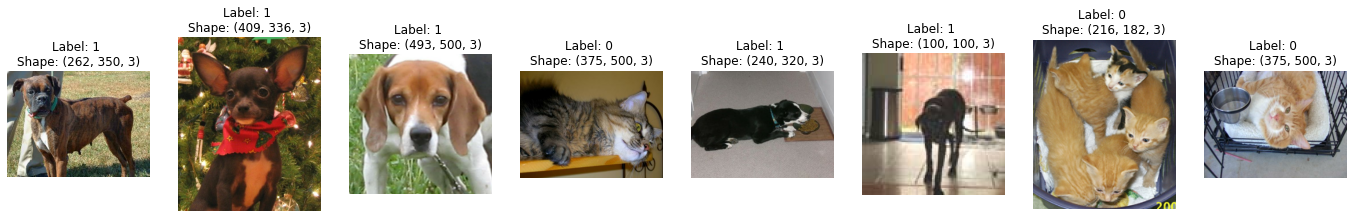

In [3]:
num_samples=8
index = 1
plt.figure(figsize=(24, 4))
for image, label in dataset_train_original.take(num_samples):
  plt.subplot(1, num_samples, index)
  plt.imshow(image)
  plt.title(f"Label: {label} \nShape: {image.shape}")
  plt.axis("off")
  index +=1

In [4]:
#we need to resize the pictures so all have the same size


#Prepare the data

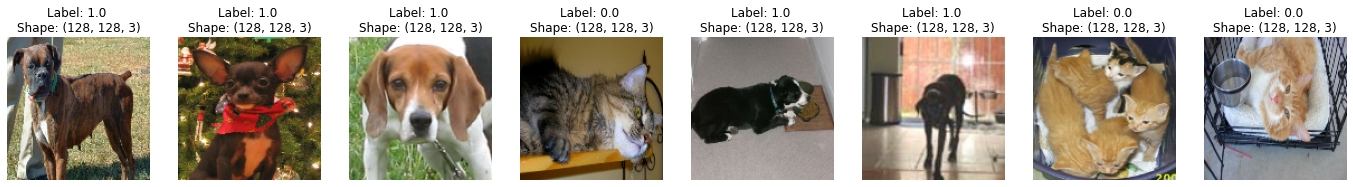

In [5]:
def encode(image, label, image_size=(128, 128)):
    image_encoded = tf.image.convert_image_dtype(image, dtype=tf.float32) #convert all to float type
    image_encoded = tf.image.resize(image_encoded, image_size) #resize all the pictures to the same size 
    label = tf.cast(label, tf.float32)
    return image_encoded, label

dataset = dataset_train_original.map(lambda image, label: encode(image, label))

num_samples=8
index = 1
plt.figure(figsize=(24, 4))
for image, label in dataset.take(num_samples):
  plt.subplot(1, num_samples, index)
  plt.imshow(image)
  plt.title(f"Label: {label} \nShape: {image.shape}")
  plt.axis("off")
  index +=1

In [6]:


dataset_train = dataset_train_original.map(lambda image, label: encode(image, label))
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(2500)
dataset_train = dataset_train.batch(128)

dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(128)

# Prepare the experiments.

In [7]:
history_dict = {}
epochs = 50

In [8]:
def render_history(history):
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.title("Our losses")
    plt.show()
    plt.close()

    plt.plot(history["accuracy"], label="accuracy")
    plt.plot(history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.title("Our accuracies")
    plt.show()
    plt.close()


def compare_histories():
    for training_name, history in history_dict.items():
        plt.plot(history["val_accuracy"], label=training_name)
    plt.legend()
    plt.title("Comparison of val_accuracy")
    plt.show()
    plt.close()


# Experiment 1: Train a CNN from scratch 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

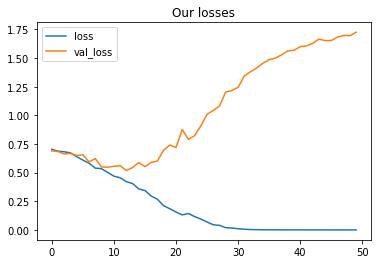

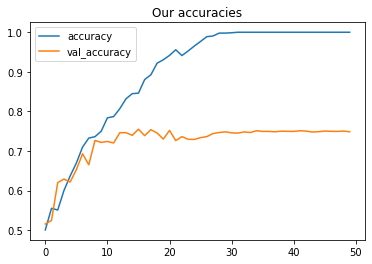

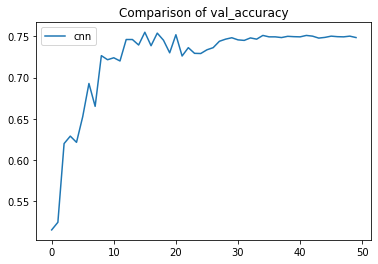

In [9]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(128, 128, 3)))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid")) #last one is sigmoid because on the sigmoid the values that calculates are closer to 1 and 0
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy", #binary because there are only 2 categories(cat(dog). when there are more we use categorical cross entropy
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_validate
)

history_dict["cnn"] = history.history
render_history(history.history)
compare_histories() 

# Experiment 2: Data Augmentation

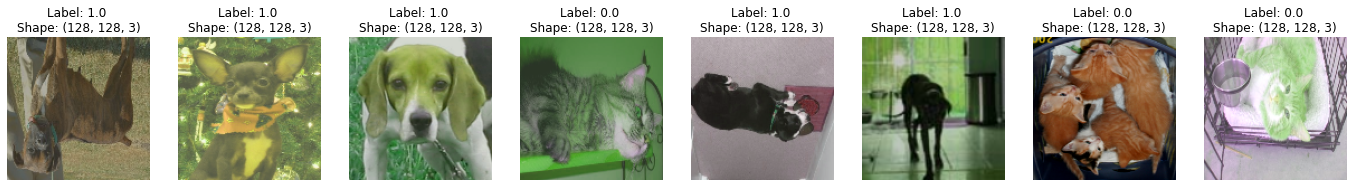

In [10]:
def augment(image, label):
    image_augmented = image
    image_augmented = tf.image.random_flip_left_right(image_augmented) #it selects randomly which one applies(left, right, up or down). #erevy time we train the data chooses randomly one
    image_augmented = tf.image.random_flip_up_down(image_augmented)
    image_augmented = tf.image.random_contrast(image_augmented, 0.5, 1.0)
    image_augmented = tf.image.random_brightness(image_augmented, 0.25)
    image_augmented = tf.image.random_hue(image_augmented, 0.2)
    image_augmented = tf.clip_by_value(image_augmented, 0.0, 1.0)
    return image_augmented, label

dataset = dataset_train_original.map(lambda image, label: encode(image, label))
dataset = dataset.map(lambda image, label: augment(image, label))


num_samples=8
index = 1
plt.figure(figsize=(24, 4))
for image, label in dataset.take(num_samples):
  plt.subplot(1, num_samples, index)
  plt.imshow(image)
  plt.title(f"Label: {label} \nShape: {image.shape}")
  plt.axis("off")
  index +=1

In [11]:
dataset_train_augmented = dataset_train_original.map(lambda image, label: encode(image, label))
dataset_train_augmented = dataset_train_augmented.cache() #we put the cache her because only on the original data the pictures are the same, even if we shuffle
dataset_train_augmented = dataset_train_augmented.map(lambda image, label: augment(image, label))
dataset_train_augmented = dataset_train_augmented.shuffle(2500)
dataset_train_augmented = dataset_train_augmented.batch(128)
 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

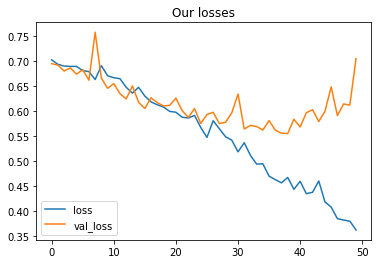

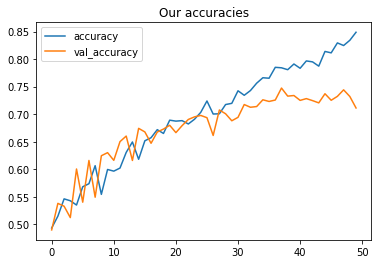

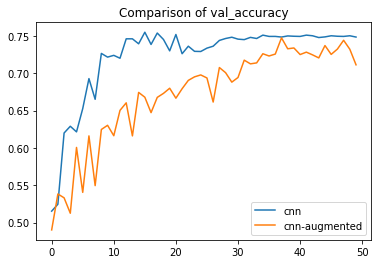

In [12]:
tf.keras.backend.clear_session() #this is to free GPU memory

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(128, 128, 3)))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid")) #last one is sigmoid because on the sigmoid the values that calculates are closer to 1 and 0
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy", #binary because there are only 2 categories(cat(dog). when there are more we use categorical cross entropy
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train_augmented,
    epochs=epochs,
    validation_data=dataset_validate
)

history_dict["cnn-augmented"] = history.history
render_history(history.history)
compare_histories() 

# Experiment 3: Dropout

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

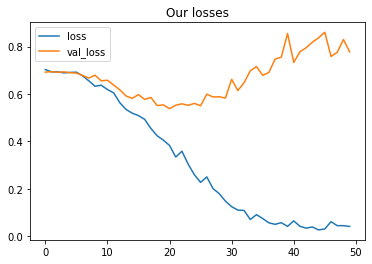

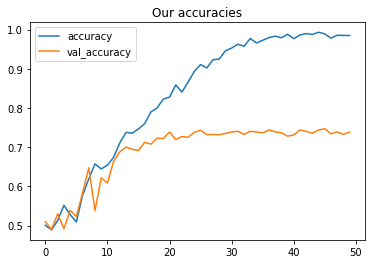

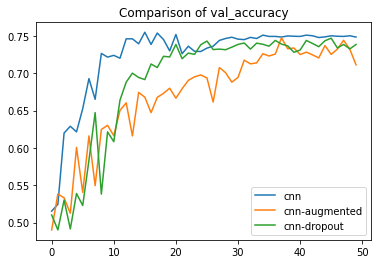

In [13]:
tf.keras.backend.clear_session() #this is to free GPU memory

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(128, 128, 3)))
model.add(layers.Dropout(0.1))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(layers.Dropout(0.15))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.Dropout(0.2))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(layers.Dropout(0.25))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.3)) #we put at the end because at the end the CNN has less noise and more signal(information). at the beginning has big noise and signal 
model.add(layers.Dense(1, activation="sigmoid")) #last one is sigmoid because on the sigmoid the values that calculates are closer to 1 and 0
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy", #binary because there are only 2 categories(cat(dog). when there are more we use categorical cross entropy
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train, #we dont put augmented now, to test with or without augmented 
    epochs=epochs,
    validation_data=dataset_validate
)

history_dict["cnn-dropout"] = history.history
render_history(history.history)
compare_histories() 

#Experiment 4: Tranfer learning

80150528/80134624 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 128)               1048704   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 21,073,217
Trainable params: 1,048,833
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/50
19/19 [==============================] - 21s 913ms/step - loss: 0.9837 - accuracy: 0.5464 - 

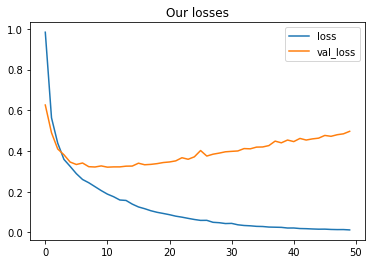

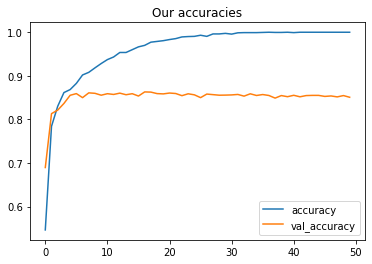

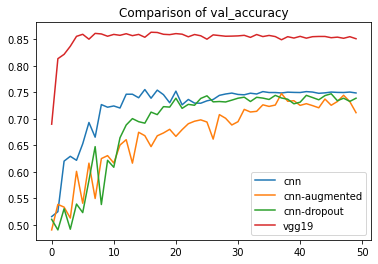

In [14]:
#!nvidia-smi  command to see how much GPU memory we have used 
tf.keras.backend.clear_session()

base_net = tf.keras.applications.VGG19(
    include_top=False,
    input_shape=(128, 128, 3)
)
base_net.trainable = False #freezing the weights.
#base_net.summary()

model = models.Sequential()
model.add(base_net)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy", #binary because there are only 2 categories(cat(dog). when there are more we use categorical cross entropy
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train, #we dont put augmented now, to test with or without augmented 
    epochs=epochs,
    validation_data=dataset_validate
)

history_dict["vgg19"] = history.history
render_history(history.history)
compare_histories() 

In [15]:
#now we try with resnet152v2 instead of vgg19

234561536/234545216 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 4, 4, 2048)        58331648  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 128)               4194432   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 62,526,209
Trainable params: 4,194,561
Non-trainable params: 58,331,648
_________________________________________________________________
Epoch 1/50
19/19 [==============================] - 29s 1s/step - loss: 1.2353 - accuracy: 0.8908 - v

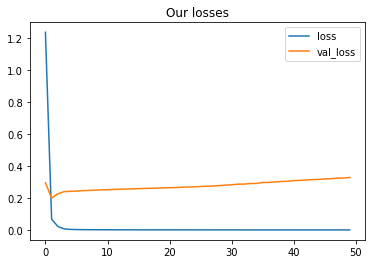

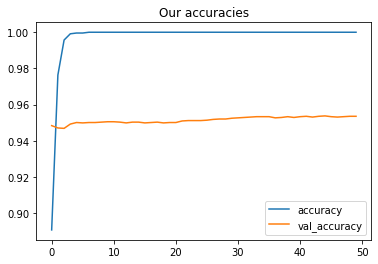

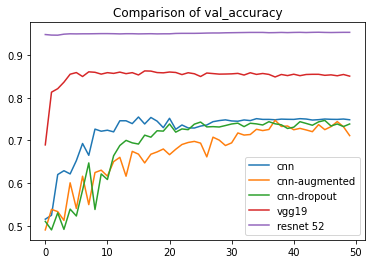

In [16]:
#!nvidia-smi  command to see how much GPU memory we have used 
tf.keras.backend.clear_session()

base_net = tf.keras.applications.ResNet152V2(
    include_top=False,
    input_shape=(128, 128, 3)
)
base_net.trainable = False #freezing the weights.
#base_net.summary()

model = models.Sequential()
model.add(base_net)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy", #binary because there are only 2 categories(cat(dog). when there are more we use categorical cross entropy
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train, #we dont put augmented now, to test with or without augmented 
    epochs=epochs,
    validation_data=dataset_validate
)

history_dict["resnet 52"] = history.history
render_history(history.history)
compare_histories() 

In [17]:
#now we try with EfficientNetV2L

473186304/473176280 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Functiona  (None, 4, 4, 1280)       117746848 
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 20480)             0         
                                                                 
 dense (Dense)               (None, 128)               2621568   
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 120,368,545
Trainable params: 2,621,697
Non-trainable params: 117,746,848
_________________________________________________________________
Epoch 1/50
19/19 [===============

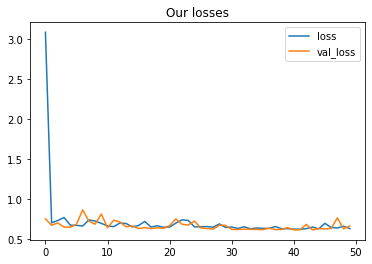

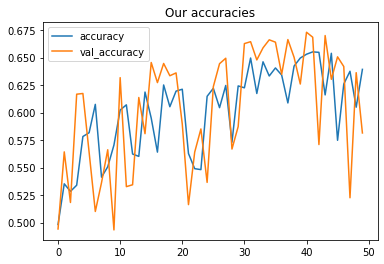

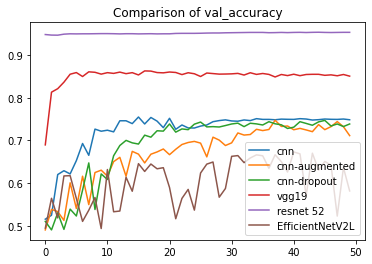

In [18]:
#!nvidia-smi  command to see how much GPU memory we have used 
tf.keras.backend.clear_session()

base_net = tf.keras.applications.EfficientNetV2L(
    include_top=False,
    input_shape=(128, 128, 3)
)
base_net.trainable = False #freezing the weights.
#base_net.summary()

model = models.Sequential()
model.add(base_net)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

model.compile(
    optimizer="adam",
    loss="binary_crossentropy", #binary because there are only 2 categories(cat(dog). when there are more we use categorical cross entropy
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train, #we dont put augmented now, to test with or without augmented 
    epochs=epochs,
    validation_data=dataset_validate
)

history_dict["EfficientNetV2L"] = history.history
render_history(history.history)
compare_histories() 

In [19]:
#we change the image size and we add dropout

In [20]:
image_size = (192,192)

dataset_train = dataset_train_original.map(lambda image, label: encode(image, label, image_size=image_size))
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(2500)
dataset_train = dataset_train.batch(128)

dataset_validate = dataset_validate_original.map(lambda image, label: encode(image, label, image_size=image_size))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(128)

9420800/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten (Flatten)           (None, 46080)             0         
                                                                 
 dense (Dense)               (None, 128)               5898368   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 8,156,481
Trainable params: 5,898,497
Non-tra

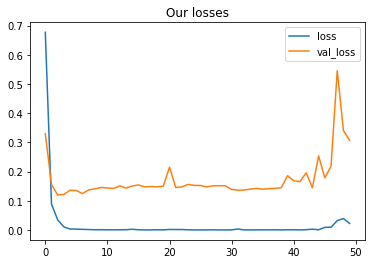

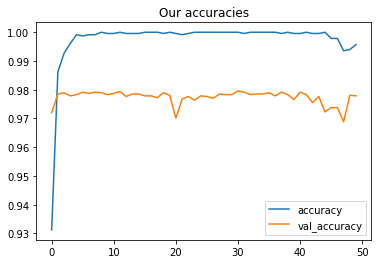

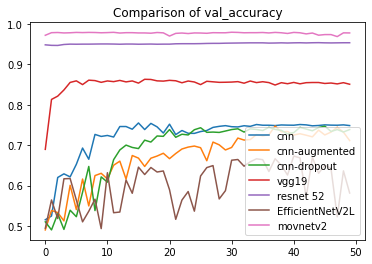

In [21]:
tf.keras.backend.clear_session()

base_net = tf.keras.applications.MobileNetV2(
    include_top=False,
    input_shape=image_size + (3,) # (192, 192, 3) we hjave changed the size avove, before was (128, 128)
)
base_net.trainable = False #freezing the weights.
#base_net.summary()

model = models.Sequential()
model.add(base_net)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()




model.compile(
    optimizer="adam",
    loss="binary_crossentropy", #binary because there are only 2 categories(cat(dog). when there are more we use categorical cross entropy
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train, #we dont put augmented now, to test with or without augmented 
    epochs=epochs,
    validation_data=dataset_validate
)

history_dict["movnetv2"] = history.history
render_history(history.history)
compare_histories() 

In [22]:
#we increase more the image size

In [23]:
image_size=(280,280)

dataset_train = dataset_train_original.map(lambda image, label: encode(image,label,image_size=image_size))
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(2500)
dataset_train = dataset_train.batch(128)

dataset_validate = dataset_validate_original.map(lambda image, label: encode(image,label,image_size=image_size))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(128)

In [24]:
epochs=10
tf.keras.backend.clear_session()
inception_v3 = tf.keras.applications.InceptionV3(
    include_top=False, #removes the bottom 3 layers
    input_shape = (280,280,3) #input shape for our model
)
inception_v3.trainable = False #Freezing the weights
#base_net.summary()
model = models.Sequential()
model.add(inception_v3)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_validate
)

87924736/87910968 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 7, 7, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 256)               25690368  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                         